In [1]:
import numpy as np
import torch
from cmb_ps import CMBPS
import matplotlib.pyplot as plt
from inference import *
import arviz as az

In [2]:
device = 0

In [3]:
ps_model = CMBPS(norm_phi=True).to(device)
phi = sample_prior(5, device=device)
x = gen_x(phi, ps_model, device=device)

In [4]:
nchains = x.shape[0]
nsamples = 200
burnin = 20
step_size = 0.001
nleap = 30
epsadapt = 0

sampler = infer(x,
                ps_model,
                nchains=nchains,
                nsamples=nsamples,
                burnin=burnin,
                step_size=step_size,
                nleap=nleap,
                epsadapt=epsadapt,
                device=device)

100%|██████████| 220/220 [05:17<00:00,  1.44s/it]


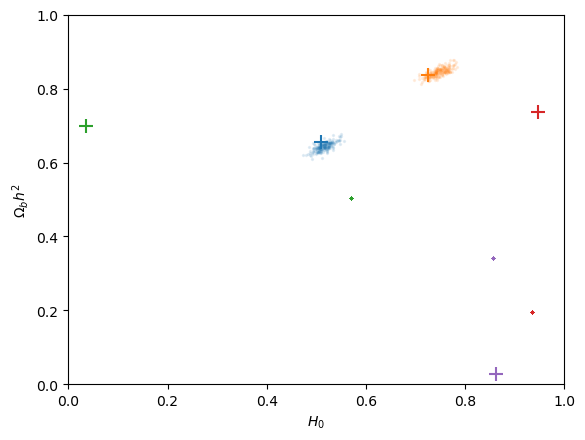

In [5]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

samples = sampler.samples.cpu().numpy()
truth = phi.detach().cpu().numpy()

plt.figure()
for i in range(nchains):
    color = color_cycle[i % len(color_cycle)]
    plt.scatter(samples[i, :, 0], samples[i, :, 1], s=2, alpha=0.1, color=color)
    plt.scatter(truth[i, 0], truth[i, 1], s=100, marker='+', color=color)
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()